### Warehouse location problem (week 11)

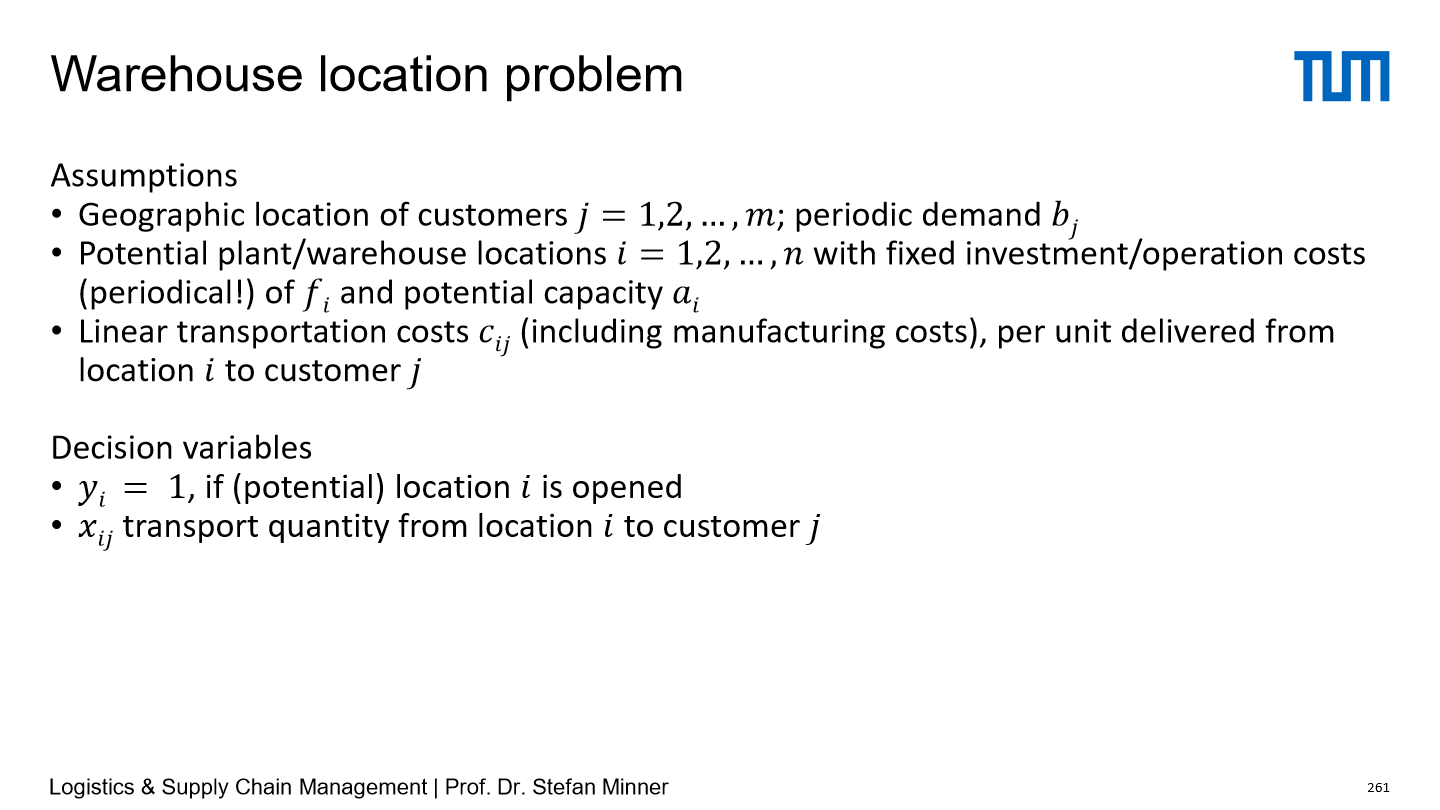

![Alt text](image.png)

In [2]:
import folium, random

random.seed('012345')

MUC_COORD = [48.13710, 11.57561]

tilesetstyles = ['cartodbpositron', 'stamenterrain', 'OpenStreetMap']
tileset = tilesetstyles[1]

# Build map 
map_muc = folium.Map(location=MUC_COORD, zoom_start=11, 
tiles=tileset, width=640, height=480)

latitude_min = 48.2050
latitude_max = 48.0562
longitude_min = 11.4153
longitude_max = 11.7664
demand_max = 3
capacity_max = 30
fixedCosts_max = 50
nCustomers = 50
nLocations = 10

customers = []
for i in range(nCustomers):
    customers.append({
        "lat": random.uniform(latitude_min, latitude_max), 
        "long": random.uniform(longitude_min, longitude_max),
        "demand": random.uniform(0, demand_max)
    })
locations = []
for i in range(nLocations):
    locations.append({
        "lat": random.uniform(latitude_min, latitude_max), 
        "long": random.uniform(longitude_min, longitude_max),
        "capacity": random.uniform(0, capacity_max),
        "fixedCosts": fixedCosts_max  # random.uniform(0, fixedCosts_max)
    })

if sum([l["capacity"] for l in locations]) < sum([c["demand"] for c in customers]):
    print("Total capacity not sufficient!")

[folium.CircleMarker([c["lat"], c["long"]], radius = c["demand"], color='#3186cc', fill_color='#3186cc', fill_opacity=1.0,).add_to(map_muc)
  for c in customers]
[folium.CircleMarker([c["lat"], c["long"]], radius = c["capacity"], color='grey', fill_color='grey', fill_opacity=1.0,).add_to(map_muc)
  for c in locations]

map_muc

Calculate distances based on https://en.kompf.de/gps/distcalc.html (Euclidean distance in km based on latitude and longitude considering earth curvature)

In [3]:
from math import sin, cos, sqrt, atan2, radians

distance = {}

R = 6373.0 # radius of earth
for i in range(nLocations):
    lat0 = radians(locations[i]["lat"])
    lon0 = radians(locations[i]["long"])
    for j in range(nCustomers):
        lat1 = radians(customers[j]["lat"])
        lon1 = radians(customers[j]["long"])

        dlat = lat1 - lat0
        dlon = lon1 - lon0

        a = sin(dlat / 2) ** 2 + cos(lat0) * cos(lat1) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        # distance in km
        distance[i, j] = R * c

In [4]:
import gurobipy as gp
from gurobipy import GRB

model = gp.Model()

x = {}
for i in range(nLocations):
    for j in range(nCustomers):
        x[i, j] = model.addVar(vtype=GRB.CONTINUOUS, lb = 0)
y = {}
for i in range(nLocations):
    y[i] = model.addVar(vtype=GRB.BINARY)

# demand is served
for j in range(nCustomers):
    model.addConstr(
        gp.quicksum(x[i, j] for i in range(nLocations)) == customers[j]["demand"]
    )
# capacity
for i in range(nLocations):
    model.addConstr(
        gp.quicksum(x[i, j] for j in range(nCustomers)) <= locations[i]["capacity"] * y[i]
    )

model.setObjective(
    gp.quicksum(locations[i]["fixedCosts"] * y[i] for i in range(nLocations)) 
    + gp.quicksum(x[i, j]*distance[i, j] for i in range(nLocations) for j in range(nCustomers))
    , GRB.MINIMIZE)
            
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 60 rows, 510 columns and 1010 nonzeros
Model fingerprint: 0x3a5eae30
Variable types: 500 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [6e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+00]
Presolve time: 0.02s
Presolved: 60 rows, 510 columns, 1010 nonzeros
Variable types: 500 continuous, 10 integer (10 binary)
Found heuristic solution: objective 754.1995115

Root relaxation: objective 6.317367e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  631.73675    0    5  754.19951  631.

In [5]:
for i in range(nLocations):
    for j in range(nCustomers):
        if x[i, j].x > 0:
            points = [
                [locations[i]["lat"], locations[i]["long"]], 
                [customers[j]["lat"], customers[j]["long"]]
            ]
            folium.PolyLine(points, weight=2, color='black', opacity=1).add_to(map_muc)
[folium.CircleMarker(
    [locations[i]["lat"], locations[i]["long"]], 
    radius = locations[i]["capacity"], 
    color=('green' if (y[i].x > 0) else 'red'), 
    fill_color=('green' if (y[i].x > 0) else 'red'), 
    fill_opacity=1.0
).add_to(map_muc) for i in range(nLocations)]
[folium.CircleMarker(
    [c["lat"], c["long"]], 
    radius = c["demand"], 
    color='#3186cc', 
    fill_color='#3186cc', 
    fill_opacity=1.0
).add_to(map_muc) for c in customers]
map_muc